In [ ]:
### Init

In [46]:
import numpy as np
import random
import pandas as pd
import torch

# Simple Example

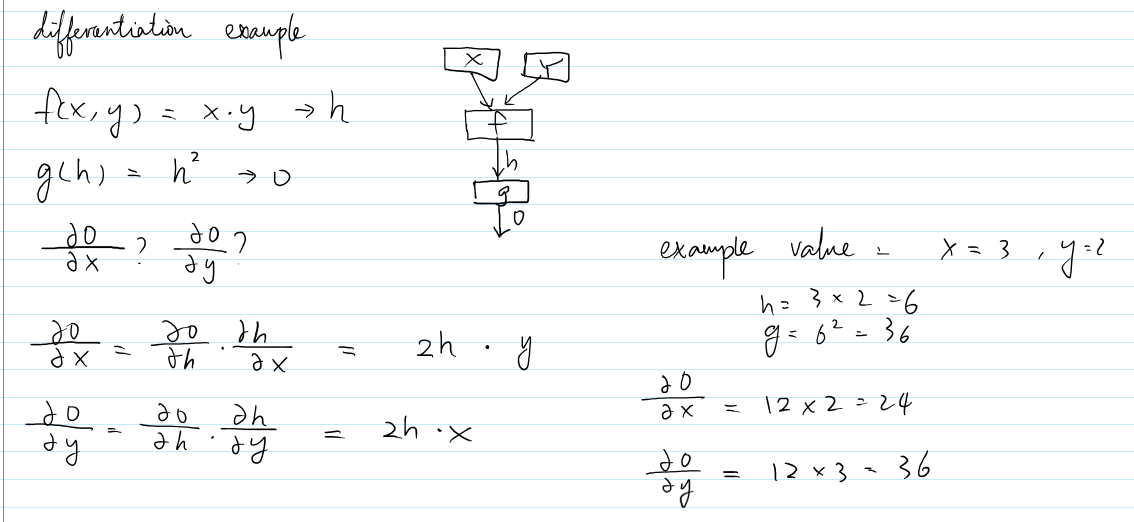

$$\nabla f = [y, x]^{\top}$$
$$\nabla g = [2h]^{\top}$$

In [1]:
import numpy as np

In [2]:
class ComputeNode(object):
    def __init__(self, tape):
        self.tape = tape
    
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError

In [3]:
class F(ComputeNode):
    def forward(self, inputs):
        self.tape[self] = inputs
        out = inputs[0] * inputs[1]
        return np.atleast_1d(out)
    
    def backward(self, grad):
        inputs = self.tape[self]
        return np.array([inputs[1], inputs[0]]) * grad
        
class G(ComputeNode):
    def forward(self, inputs):
        self.tape[G] = inputs
        out = np.atleast_1d(inputs[0] ** 2)
        return out
    
    def backward(self, grad):
        return (self.tape[G] * 2) * grad

In [4]:
tape = {}
f = F(tape)
g = G(tape)

In [5]:
x = 3
y = 2

In [6]:
inputs = np.array([x, y])

In [7]:
outputs = f.forward(inputs)
print(outputs)
outputs = g.forward(outputs)
print(outputs)

[6]
[36]


In [8]:
grads = g.backward(np.array([1]))
print(grads)
grads = f.backward(grads)
print(grads)

[12]
[24 36]


# An intricate chain rule example

[link](https://cs231n.github.io/optimization-2/#backprop)

$$f(x, y)=\frac{x+\sigma(y)}{\sigma(x)+(x+y)^{2}}$$

In [9]:
import math

In [19]:
x = 3 # example values
y = -4

# forward pass
sigy = 1.0 / (1 + math.exp(-y)) # sigmoid in numerator   #(1)
num = x + sigy # numerator                               #(2)
sigx = 1.0 / (1 + math.exp(-x)) # sigmoid in denominator #(3)
xpy = x + y                                              #(4)
xpysqr = xpy**2                                          #(5)
den = sigx + xpysqr # denominator                        #(6)
invden = 1.0 / den                                       #(7)
f = num * invden # done!                                 #(8)

In [20]:
# backprop f = num * invden
dx = 0
dy = 0

dnum = invden
dx += 1 * dnum
dy += (1 - sigy) * sigy * dnum

dinvden = num
dden = - (1 / den) ** 2 * dinvden
dsigx = dden
dx += (1 - sigx) * sigx * dsigx
dxpysqr = dden
dx += (2 * x + 2 * y) * dxpysqr
dy += (2 * y + 2 * x) * dxpysqr

print(dx, dy)

2.0595697955721652 1.5922327514838093


# Fully Connected for Prediction

In [21]:
class Layer(object):
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError

In [22]:
# class SequentialTape(object):
#     def __init__(self, layers):
#         self.layers = layers
#         self.parameters = {}
        
#     def forward(self, x):
#         pass
    
#     def backward(self):
#         pass
    
#     def step(self):
        

In [140]:
class MLP(Layer):
    def __init__(self, d_in, d_out):
        self.d_in = d_in
        self.d_out = d_out
        self.A = np.random.randn(d_out, d_in) * np.sqrt(2 / d_in)
        self.b = np.zeros(d_out)
        
        self.dx = np.zeros((d_out, d_in))
        self.db = np.zeros(d_out)
        self.dA = None  # based on batch_size, [d_out, n]
        
        self.chain_db = None
        self.chain_dA = None
        
    def forward(self, x):
        self.dx += self.A  # [d_out d_in]
        self.db += np.ones_like(self.b)  # [d_out]
        if self.dA is None:
            self.dA = np.zeros_like(x)
        self.dA += x  # [n d_in]
            
        return x @ self.A.T + self.b
    
    def backward(self, grads):
        # A: [d_out d_in]
        # x: [n d_in]
        # b: [d_out]
        # grads: [n d_out]
        n = grads.shape[0]
        
        chain_dA = np.zeros_like(self.A)
        for idx in range(n):
            chain_dA += np.outer(grads[idx], self.dA[idx])
        self.chain_dA = chain_dA
        
        chain_db = grads.sum(axis=0) * self.db
        self.chain_db = chain_db
        
        chain_dx = np.zeros_like(x)  # [n d_in]
        chain_dx = grads @ self.dx
            
        return chain_dx
    
    def step(self, alpha=0.01, decay=None):
        self.A -= alpha * self.chain_dA
        self.b -= alpha * self.chain_db
        if decay:
            self.A -= decay * np.sqrt(self.A ** 2)
            self.b -= decay * np.sqrt(self.b ** 2)
        
    def reset(self):
        self.dx = np.zeros((self.d_out, self.d_in))
        self.db = np.zeros(self.d_out)
        self.dA = None  # based on batch_size, [d_out, n]
        
        self.chain_db = None
        self.chain_dA = None
    
class MSE(Layer):
    def __init__(self):
        self.dy = None
        
    def forward(self, y_pred, y_target):
        # y: [n]
        # target: [n]
        # dx: -2 * target + 2 * y
        if self.dy is None:
            self.dy = np.zeros((y_pred.shape[0], 1))
        self.dy += (-2 * y_target + 2 * y_pred)
        return np.sum((y_target - y_pred) ** 2)
        
    def backward(self):
        return self.dy
    
class ReLu(Layer):
    def __init__(self):
        self.dx = None
    
    def forward(self, x):
        # x: [n d_out]
        self.dx = (x > 0).astype(int)
        return x * (x > 0)
    
    def backward(self, grads):
        # grads: [n d_out]
        return grads * self.dx
        
    def step(self, *args, **kwargs):
        pass
    
    def reset(self):
        self.dx = None
        
class Sigmoid(Layer):
    def __init__(self):
        self.dx = None
    
    def forward(self, x):
        # x: [n d_out]
        self.dx = (1 - x) * x
        return np.exp(x) / (1 + np.exp(-x + 1e-7))
    
    def backward(self, grads):
        # grads: [n d_out]
        return grads * self.dx
        
    def step(self, *args, **kwargs):
        pass
    
    def reset(self):
        self.dx = None

In [141]:
def comp_gradients(a, b):
    print('diff: ', (a - b).sum())
    relative_error_max = np.max(np.abs(np.append(a, b)))
    return np.mean(np.abs(a - expected_grad) / relative_error_max)

def forward(layers, x):
    for layer in layers:
        x = layer.forward(x)
    return x

def backward(layers, grads):
    for layer in reversed(layers):
#         print('grads.shape', grads.shape)
        grads = layer.backward(grads)
    return grads

In [142]:
batch_size = 8

In [143]:
data = pd.read_csv("winequality-red.csv", delimiter=';').to_numpy()
for column in range(data.shape[1]):
    col = data[:, column] 
    col -= np.min(col)
    col /= np.max(col)
    
data_x, data_y = np.hsplit(data, np.array([11]))
batches = []
for idx in range(0, len(data_x), batch_size):
    batch_x = data_x[idx:idx + batch_size]
    batch_y = data_y[idx:idx + batch_size]
    if len(batch_x) == batch_size:
        batches.append((batch_x, batch_y))

In [157]:
dim_x = data_x.shape[1]
dim_h1 = 16
dim_h2 = 16
dim_h3 = 8

In [160]:
layers = [
    MLP(dim_x, dim_h1),
    ReLu(),
    MLP(dim_h1, dim_h2),
    ReLu(),
    MLP(dim_h2, dim_h3),
    ReLu(),
    MLP(dim_h3, 1),
    Sigmoid()
]
loss_fn = MSE()

random.shuffle(batches)
for epoch in range(500):
    losses = []
    for batch_x, batch_y in batches:
        y = forward(layers, batch_x)
        loss = loss_fn.forward(y, batch_y)
        grads = loss_fn.backward()
        backward(layers, grads)
        for layer in layers:
            layer.step(alpha=1e-10, decay=1e-12)
            layer.reset()
        losses.append(loss)
    print(f"epoch: {epoch}, loss: {np.mean(losses)} ")
    losses.clear()

epoch: 0, loss: 0.22093497784243657 
epoch: 1, loss: 0.2209351176980307 
epoch: 2, loss: 0.22093539382569452 
epoch: 3, loss: 0.22093580624870865 
epoch: 4, loss: 0.2209363550017813 
epoch: 5, loss: 0.22093704013105292 
epoch: 6, loss: 0.22093786169410246 
epoch: 7, loss: 0.22093881975995452 
epoch: 8, loss: 0.22093991440908867 
epoch: 9, loss: 0.22094114573345064 
epoch: 10, loss: 0.22094251383646382 
epoch: 11, loss: 0.22094401883304332 
epoch: 12, loss: 0.2209456608496111 
epoch: 13, loss: 0.22094744002411282 
epoch: 14, loss: 0.2209493565060361 
epoch: 15, loss: 0.22095141045642983 
epoch: 16, loss: 0.2209536020479271 
epoch: 17, loss: 0.22095593146476647 
epoch: 18, loss: 0.22095839890281674 
epoch: 19, loss: 0.22096100456960346 
epoch: 20, loss: 0.22096374868433633 
epoch: 21, loss: 0.22096663147793852 
epoch: 22, loss: 0.22096965319307668 
epoch: 23, loss: 0.22097281408419356 
epoch: 24, loss: 0.2209761146212918 
epoch: 25, loss: 0.22097955551508658 
epoch: 26, loss: 0.220983136

epoch: 215, loss: 0.22542351924837487 
epoch: 216, loss: 0.22548037892926168 
epoch: 217, loss: 0.22553819339241096 
epoch: 218, loss: 0.22559675904299623 
epoch: 219, loss: 0.22565612214760394 
epoch: 220, loss: 0.22571580207598751 
epoch: 221, loss: 0.2257756968891056 
epoch: 222, loss: 0.2258362662669535 
epoch: 223, loss: 0.2258975175291678 
epoch: 224, loss: 0.22595940553237093 
epoch: 225, loss: 0.22602175593316284 
epoch: 226, loss: 0.22608406204035325 
epoch: 227, loss: 0.22614707601674222 
epoch: 228, loss: 0.2262108079829386 
epoch: 229, loss: 0.22627517987117213 
epoch: 230, loss: 0.22634013269938974 
epoch: 231, loss: 0.22640555767725187 
epoch: 232, loss: 0.22647162906872295 
epoch: 233, loss: 0.22653844756097757 
epoch: 234, loss: 0.2266062739743594 
epoch: 235, loss: 0.2266749115477902 
epoch: 236, loss: 0.22674414793489675 
epoch: 237, loss: 0.22681424088999122 
epoch: 238, loss: 0.22688522021438232 
epoch: 239, loss: 0.22695690974784785 
epoch: 240, loss: 0.22702955916

epoch: 429, loss: 0.29853263155980975 
epoch: 430, loss: 0.3000113870555161 
epoch: 431, loss: 0.30152492738335934 
epoch: 432, loss: 0.3030743181824869 
epoch: 433, loss: 0.30466691884198377 
epoch: 434, loss: 0.3062995042460836 
epoch: 435, loss: 0.3079729400073795 
epoch: 436, loss: 0.30968805693746065 
epoch: 437, loss: 0.3114456865625264 
epoch: 438, loss: 0.31324440813558324 
epoch: 439, loss: 0.315089211013097 
epoch: 440, loss: 0.31698520103101124 
epoch: 441, loss: 0.31893135361754166 
epoch: 442, loss: 0.32093478984960094 
epoch: 443, loss: 0.3229957651527339 
epoch: 444, loss: 0.32511393442646064 
epoch: 445, loss: 0.3272936329669408 
epoch: 446, loss: 0.32953099289833304 
epoch: 447, loss: 0.3318266062123956 
epoch: 448, loss: 0.33419346846402936 
epoch: 449, loss: 0.3366346786865274 
epoch: 450, loss: 0.33914618277444103 
epoch: 451, loss: 0.34173595063416196 
epoch: 452, loss: 0.34440099086260406 
epoch: 453, loss: 0.3471507867903923 
epoch: 454, loss: 0.3499839312893626 

In [ ]:
x = np.random.randn(n, d_1).round(1)

mlp = MLP(d_1, d_2)
mlp.A = mlp.A.round(1)
mlp2 = MLP(d_2, d_3)
mlp2.A = mlp2.A.round(1)
layers = [mlp, mlp2]

y = forward(layers, x)
grads = backward(layers, np.ones((n, d_3)))

print('x', x)
print()
print('mlp.A', mlp.A)
print()
print('mlp2.A', mlp2.A)
print()
print('y', y)
print()
print('grads', grads)
print()
print('chain_dA', mlp.chain_dA)
print('chain_db', mlp.chain_db)

In [286]:
layers = [
    MLP(in_features, 32),
    ReLu(),
    MLP(32, 10),
    ReLu(),
    Softmax()
]

x = data
for layer in layers:
    x = layer.forward(x)
loss = cross_entropy_loss(x, target)

In [122]:
import pandas as pd

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.use('Agg')

# 2 actions
ACTIONS = [0, 1]

# each transition has a probability to terminate with 0
TERMINATION_PROB = 0.1

# maximum expected updates
MAX_STEPS = 20000

# epsilon greedy for behavior policy
EPSILON = 0.1


# break tie randomly
def argmax(value):
    max_q = np.max(value)
    return np.random.choice([a for a, q in enumerate(value) if q == max_q])


class Task:
    # @n_states: number of non-terminal states
    # @b: branch
    # Each episode starts with state 0, and state n_states is a terminal state
    def __init__(self, n_states, b):
        self.n_states = n_states
        self.b = b

        # transition matrix, each state-action pair leads to b possible states
        self.transition = np.random.randint(n_states, size=(n_states, len(ACTIONS), b))

        # it is not clear how to set the reward, I use a unit normal distribution here
        # reward is determined by (s, a, s')
        self.reward = np.random.randn(n_states, len(ACTIONS), b)

    def step(self, state, action):
        if np.random.rand() < TERMINATION_PROB:
            return self.n_states, 0
        next_ = np.random.randint(self.b)
        return self.transition[state, action, next_], self.reward[state, action, next_]


# Evaluate the value of the start state for the greedy policy
# derived from @q under the MDP @task
def evaluate_pi(q, task):
    # use Monte Carlo method to estimate the state value
    runs = 1000
    returns = []
    for r in range(runs):
        rewards = 0
        state = 0
        while state < task.n_states:
            action = argmax(q[state])
            state, r = task.step(state, action)
            rewards += r
        returns.append(rewards)
    return np.mean(returns)


# perform expected update from a uniform state-action distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def uniform(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    for step in tqdm(range(MAX_STEPS)):
        state = step // len(ACTIONS) % task.n_states
        action = step % len(ACTIONS)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance)


# perform expected update from an on-policy distribution of the MDP @task
# evaluate the learned q value every @eval_interval steps
def on_policy(task, eval_interval):
    performance = []
    q = np.zeros((task.n_states, 2))
    state = 0
    for step in tqdm(range(MAX_STEPS)):
        if np.random.rand() < EPSILON:
            action = np.random.choice(ACTIONS)
        else:
            action = argmax(q[state])

        next_state, _ = task.step(state, action)

        next_states = task.transition[state, action]
        q[state, action] = (1 - TERMINATION_PROB) * np.mean(
            task.reward[state, action] + np.max(q[next_states, :], axis=1))

        if next_state == task.n_states:
            next_state = 0
        state = next_state

        if step % eval_interval == 0:
            v_pi = evaluate_pi(q, task)
            performance.append([step, v_pi])

    return zip(*performance)


def figure_8_8():
    num_states = [1000]
    branch = [1, 3, 10]
    methods = [on_policy, uniform]

    # average across 30 tasks
    n_tasks = 30

    # number of evaluation points
    x_ticks = 100

    plt.figure(figsize=(10, 20))
    for i, n in enumerate(num_states):
        plt.subplot(2, 1, i+1)
        for b in branch:
            tasks = [Task(n, b) for _ in range(n_tasks)]
            for method in methods:
                steps = None
                value = []
                for task in tasks:
                    steps, v = method(task, MAX_STEPS / x_ticks)
                    value.append(v)
                value = np.mean(np.asarray(value), axis=0)
                plt.plot(steps, value, label=f'b = {b}, {method.__name__}')
        plt.title(f'{n} states')

        plt.ylabel('value of start state')
        plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('computation time, in expected updates')

    plt.savefig('../images/figure_8_8.png')
    plt.close()

In [5]:
figure_8_8()

100%|██████████| 20000/20000 [00:26<00:00, 746.90it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../images/figure_8_8.png'